In [3]:
import pymongo
import pandas as pd
import numpy as np
from pymongo import MongoClient
from textstat.textstat import textstat
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import pickle
from statsmodels.stats.weightstats import ztest

better = pd.read_pickle('better.pkl')
slimdata = pd.read_pickle('slimdata.pkl')

In [7]:
l = [better,slimdata]
for x in l:
    print (x.describe())
    print (x.info())
    print (x.head())
    print ('========================================================')

         word_count  flesch_kincaid          year
count  24565.000000    24565.000000  24565.000000
mean     585.853654       60.010492   1985.713820
std      573.358812       12.997493     22.065415
min        0.000000     -109.880000   1957.000000
25%      159.000000       49.820000   1957.000000
50%      483.000000       60.350000   1977.000000
75%      858.000000       69.310000   2006.000000
max    20252.000000      121.220000   2018.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24565 entries, 0 to 24564
Data columns (total 10 columns):
_id                 24565 non-null object
body                24565 non-null object
section_name        3120 non-null object
new_desk            11656 non-null object
source              24565 non-null object
pub_date            24565 non-null object
type_of_material    24565 non-null object
word_count          24565 non-null int64
flesch_kincaid      24565 non-null float64
year                24565 non-null int64
dtypes: float64(1), int

In [8]:
better.head()

,_id,body,section_name,new_desk,source,pub_date,type_of_material,word_count,flesch_kincaid,year
0,5a4aca6e95d0e0246f21ed46,If the second inauguration of Mayor Bill de Bl...,NaN,Metro,The New York Times,2018-01-01T23:55:15+0000,News,936,70.84,2018
1,5a4ac96d95d0e0246f21ed45,It took 37 minutes of sitting outside in 18-de...,NaN,Metro,The New York Times,2018-01-01T23:50:57+0000,News,1087,81.73,2018
2,5a4ac57795d0e0246f21ed43,The families had striking similarities: They l...,Americas,Express,The New York Times,2018-01-01T23:34:06+0000,News,1344,61.77,2018
3,5a4ac55195d0e0246f21ed42,"SAO PAULO — Nine inmates were killed, 14 were...",Americas,None,Reuters,2018-01-01T23:33:31+0000,News,231,53.85,2018
4,5a4ac2b595d0e0246f21ed40,When it comes to artificial intelligence and j...,NaN,OpEd,The New York Times,2018-01-01T23:22:19+0000,Op-Ed,836,51.78,2018


In [12]:
def add_reading_levels(df):
    for row,body in enumerate(df['body']):
        x = df['body'][row]
        df.loc[row,'flesch_kincaid']=textstat.flesch_kincaid_grade(x)
        #df.loc[row,'smog_index']=textstat.smog_index(x)
        df.loc[row,'gunning_fog']=textstat.gunning_fog(x)
        #df.loc[row,'difficult_words']=textstat.difficult_words(x)
        #df.loc[row,'text_standard']=textstat.text_standard(x)

add_reading_levels(better)

In [14]:
better['source'].unique()

array(['The New York Times', 'Reuters', 'AP',
       'International New York Times', '', 'International Herald Tribune',
       'Bloomberg News', 'Agence France-Presse', 'Dow Jones',
       'Bridge News', 'AFX News'], dtype=object)

In [20]:
########### DROP 47.96 #################
drop_f = better

for row,x in enumerate(drop_f['flesch_kincaid']):
    if x == 47.96:
        drop_f.drop(row,inplace=True)

len(drop_f)


21983

In [21]:
##### HYPOTHESIS TEST #################
article_data = better
years = [2017,2007,1997,1987,1977,1957] #1987
comb = list(itertools.combinations(years,2))

_2017vs = [x for x in comb if 2017 in x]

#3855 is 2017

for x in _2017vs: 
    
    y2017= np.array(article_data.loc[article_data['year'] == x[0], 'flesch_kincaid'])[:3000]
    y_test = np.array(article_data.loc[article_data['year'] == x[1], 'flesch_kincaid'])[:3000]
    
    if y2017.mean()>y_test.mean():
        alt = 'larger'
    else:
        alt = 'smaller'
    
    ttest, pval = ztest(y2017,y_test,alternative=alt)
    
    print('H0: {} = {}'.format(x[0],x[1]))
    print('H1: {} != {}'.format(x[0],x[1]))
    print('{} mean flesch_kincaid {:0.3f}'.format(x[0],y2017.mean()))
    print('{} mean flesch_kincaid {:0.3f}'.format(x[1],y_test.mean()))
    print("Ztest = {:0.4f} and P-value = {}".format(ttest,pval))
    print("=====================================================")

H0: 2017 = 2007
H1: 2017 != 2007
2017 mean flesch_kincaid 63.323
2007 mean flesch_kincaid 67.677
Ztest = -1.0392 and P-value = 0.14936628381424122
H0: 2017 = 1997
H1: 2017 != 1997
2017 mean flesch_kincaid 63.323
1997 mean flesch_kincaid 63.296
Ztest = 0.0976 and P-value = 0.46112909148177067
H0: 2017 = 1977
H1: 2017 != 1977
2017 mean flesch_kincaid 63.323
1977 mean flesch_kincaid 62.811
Ztest = 1.6777 and P-value = 0.04670105562978266
H0: 2017 = 1957
H1: 2017 != 1957
2017 mean flesch_kincaid 63.323
1957 mean flesch_kincaid 55.143
Ztest = 24.8728 and P-value = 7.324128592428202e-137


In [ ]:
####### GRAB NYT COLLECTION FROM MONGO ##############
client = MongoClient()
db = client.cap_db
collection = db.nyt
articles = pd.DataFrame(list(db.nyt.find()))GRAB NYT COLLECTION FROM MONGO ##############


In [ ]:
######## FLESCH-KINCAID ### GUNNING-FOG ###############

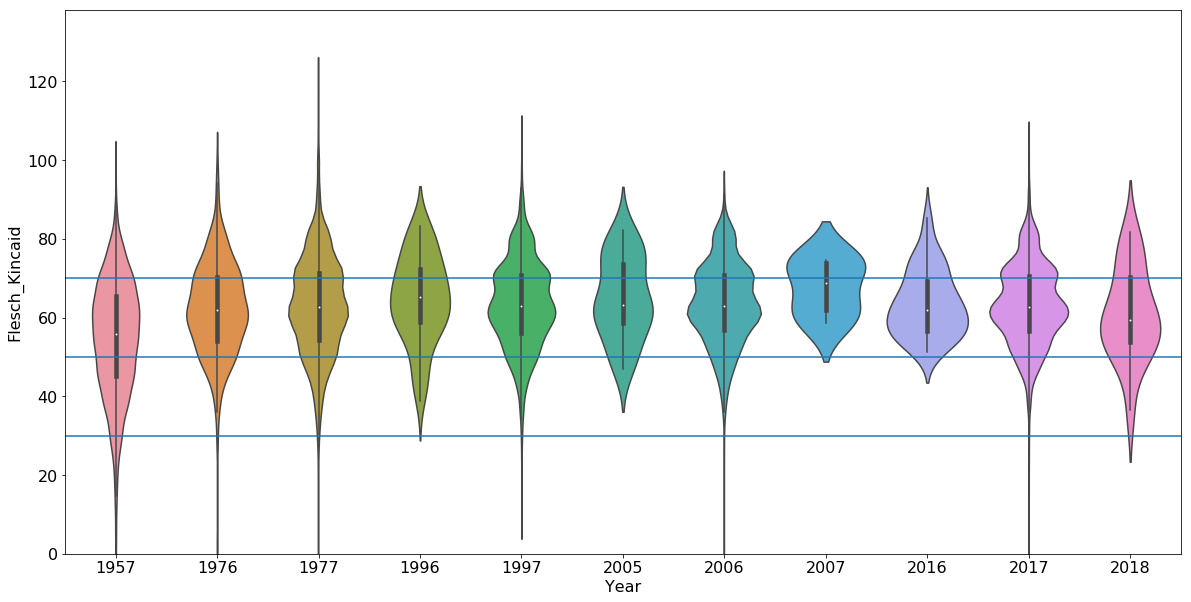

In [69]:
########## VIOLIN PLOT ################
fig = plt.figure(figsize=(20,10))
ax = sns.violinplot(x="year", y="flesch_kincaid", data=better)
ax.axhline(y=30)#PhD
ax.axhline(y=50)#College
ax.axhline(y=70)#8th Grade
ax.set_ylim(bottom=0)
ax.tick_params('both',labelsize=16)
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('Flesch_Kincaid', fontsize=16)
plt.show()

In [62]:
############# GET RIDE OF OUTLIERS ###################

In [63]:
for row,x in enumerate(better['flesch_kincaid']):
    if x<0:
        print (row,x)

3254 -8.73
4154 -6.36
4755 -30.73
5915 -87.54
6073 -75.36
6175 -6.36
6498 -56.75
6641 -56.75
6654 -56.75
6728 -72.32
6742 -81.11
12448 -30.19
14282 -47.99
14417 -48.64
15529 -47.99
15944 -47.99
16601 -6.7
16852 -109.88
17037 -47.99
19036 -0.94
21017 -0.95
21238 -2.3
21741 -4.33


In [64]:
better[better['flesch_kincaid']==-8.73]['body'].values

array(['[ Read Derek Walcott’s obituary ]'], dtype=object)

In [65]:
better[better['flesch_kincaid']==-8.73]

,_id,body,section_name,new_desk,source,pub_date,type_of_material,word_count,flesch_kincaid,year,gunning_fog
3254,58cc718695d0e02489b91c4a,[ Read Derek Walcott’s obituary ],NaN,Culture,The New York Times,2017-03-17T23:30:09+0000,Obituary (Obit),490,-8.73,2017,23.6


In [66]:
print(better[better['type_of_material']=='Obituary (Obit)'].count().sum())
print(better[better['type_of_material']=='Obituary'].count().sum())

2085
2267


TypeError: must be str, not int

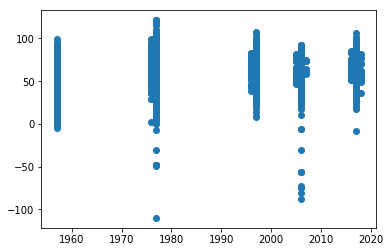

In [35]:
plt.scatter(x="year", y="flesch_kincaid",data=better)
plt.show()

In [42]:
for row,x in enumerate(better['flesch_kincaid']):
    if x>100:
        print (row,x)

better[better['flesch_kincaid']==109]['body'].values

109 101.6
1272 105.86
9301 106.37
10338 106.97
10426 102.2
11832 100.34
11899 106.97
12015 107.79
12060 118.18
12225 100.24
12343 100.75
12345 102.61
12745 115.64
13137 100.14
13164 105.66
13393 118.18
13468 100.04
13471 119.19
13516 100.34
14123 108.03
14283 121.22
14362 109.0
14539 100.24
14596 100.75
14739 105.45
15099 109.41
15196 115.64
15557 121.22
15636 121.22
15677 100.24
15681 104.64
15876 100.24
15992 102.31
16103 100.85
16210 100.24
16380 107.28
16449 107.28
16503 106.67
16590 100.24
17103 109.72
17377 100.24


array([ 'FIRTH—$7,500 pace mile\nTime—2‐01\nTUESDAY NIGHT\nSECOND—$10,??\nTime—1:58 4/5\nDouble (3‐4) paid $63.80\nTHIRD—$9.500, pace, mile\nTime—1:58 3/5. Trite?? (6.—4:10) paid $1.84\nFOURTH—$106,2??0 pace, mile\nTime—??55 1/5 ?? (2‐4) paid $176,20\nFIFTH—$106,250 pace mile\nTime—1:54 (8‐11) paid $54,40\nSIXTH—$17.000, trot, mile.\nTime 1:58 2/5 ??xacld (2‐5) paid ?? ??ed — Puritan\nSEVENTH—$13.000, pace, mile\n'], dtype=object)

In [40]:
for row,x in enumerate(better['body']):
    if len(x.split())<3:
        print (row,x)

109 It was hard to keep up with all the news, wasn’t it?
304 Ping pong diplomacy or paddle ball?
2111 Wherever you’re off to for vacation season, a retro swimsuit adds a playful touch. With high-waisted bottoms or Esther Williams-like halters, these styles have a distinctly vintage feel.
2132 “We know taking another man’s land is like taking his wife.”
PARASHUNO LEKADERO, a herder in Kenya who had recently invaded land where his animals were grazing.
2308 The haute couture crowds made stylish statements between shows during couture season in Paris.
2766 President Trump met with President Recep Tayyip Erdogan of Turkey at the White House on Tuesday. Here are a few lines from the pool report.
3254 [ Read Derek Walcott’s obituary ]
3304 A bitter dispute over the investigation into the killing of Kim Jong-nam has resulted in the nations blocking each other’s citizens from leaving the country.
3502 Our photographers caught the action backstage and between the shows on day seven of New York 

9877 STEVENS-Helen Thomas, 96, died July 7, wife of Charles H. Stevens, deceased, Survived by Charles H. Stevens, Jr., Elizabeth S. Green, Helen S. Laury and ten grandchildren.
9879 An obituary and headline about the architect William Turnbull Jr. on June 30 erroneously included a middle initial. He did not have one.
10001 JONTOW-Mary. She leaves behind a son, Bernhard L., a daughter-in-law, Eleanor J., and daughter-in-law, Sylvia; five grandchildren and nine great grandchildren.
10008 OSTRAU-Irene. Love you and miss you these long ten years. Stanley and Bert
10102 BURBAGE-Harold P. June 14, 1984. For Hal, who walks with me always. Stu
10128 HOFFER-Rose. We extend our deepest sympathies to our colleauge and friend, Philip Hoffer and his entire family, on the loss of his beloved wife Rose. Dinkes & Morelli
10175 TURI-Charles, S. On June 6, 1997. Beloved husband, father, & grandfather. Service Sun.11am ''The Riverside''76th & Amsterdam Av.
10192 An entry in the Entertainment Events listi

14258 For periods ended June 30 unless other‐i wise Indicated. (N) Indicates stock traded on the New York Stock Exchange, (A) American Stock Exchange and Over‐the‐Counter
14266 Article 7 ‐‐ No Title
14273 Horses listed In order of Post positions
Horses listed in order of post positions
EIGHTH—$10,500, pace, cl., mile.
NINTH—$8,000, pace, 2Y0, mile.
pace,
14282 CORRECTION
14283 Deaths
14291 Article 97 ‐‐ No Title
14292 Article 89 ‐‐ No Title
14293 Article 72 ‐‐ No Title
14308 Maddox, Lester, Revue: Lester Maddox illus rehearsing at RiverboatView Full Article in Timesmachine »
14321 Illus of Sequoia; Malloy will open craft for public viewing at India Point Pk (S)View Full Article in Timesmachine »
14327 Other blackout news, pages A2‐A16.
14354 Wednesday /July 12, 1977
UTILITY DORDS

14355 (Includes races of July 12)
14509 Dr. Karl Hirschfeld, shown examining patient in his optometrist shop, is one of few old‐time businessmen remaining
14556 Article 1 ‐‐ No Title
14585 illus of Gregory Pe

17335 Horses listed In order of post positions
(C) Conventional sulky. All others modi fied. *Also eligible.
17364 BUENOS AIRES, Jan. 7 (AP)—The Argentine Government reported the release of 27 political prisoners today, bringing the total freed in the last two months to 709.
17393 The price of lead increased to 26.5 cents a pound yesterday, a rise of ½ cent a pound for most products. Page 43.
17396 ENTRIES
Horses listed in order of post positions Letter designates OTB listing
RESULTS
(OTB payoffs subject to 5% State tax.)

Yonkers Drivers
Meadowlands Results

Meadowlands Drivers
17504 Article 3 — No Title
17553 Ralph Waite, left, and Brad Davis in “The Secret Life of John Chapman,” drama on Ch. 2, at 9:30 P.M.
17574 Ullmann in Bergman's “Face to Face”—“magnificently played”
17579 Scott in “Sly Fox”—“With us once again, without condescension.”
17661 Horses listed In order of Dost positions.
Aqueduct Jockeys
• Also eligible.
Meadowlands Drivers
17780 Meets at 10:30 A.M. and 3 P M.
Econom

18682 ALL BUT MY LIFE, by Gerda Weissman Klein (Hill  Wang, $3.95). The author's experiences in Nazi Germany.  View Full Article in Timesmachine »
18685 Hungary demands Israel recall 3 legation members, apparent reprisal for trial of Hungarian actor Greguss for assault on girlView Full Article in Timesmachine »
18690 LONDON, Oct. 20--Like Wall Street, the stock markets here suffered last week because of the increased tennion in the Middle Eeast.  View Full Article in Timesmachine »
18691 Reprs Martin and Taber doubt '58 cutView Full Article in Timesmachine »
18692 SMYRNA, Turkey, Oct. 20-- The Soviet radio is telling the Turkish people to vote for Republican candidates in Turkey's parliamentary elections next Sunday, ...View Full Article in Timesmachine »
18695 Philip gets impromptu gift of tie clasp from boy at football gameView Full Article in Timesmachine »
18696 5 arrive, KeelingView Full Article in Timesmachine »
18697 MOUNT HERMON, Mass., Oct. 19--Andover scored a 31-8 football v

19367 Australia to accept 5,000 more, including 2,000 in YugoslaviaView Full Article in Timesmachine »
19368 The heaviest rainfall in ten months virtually swamped the long-arid metropolitan area yesterday.View Full Article in Timesmachine »
19370 cuts prices on all polymer-coated cellophane 5&#162; a lb; adds new type to standard lineView Full Article in Timesmachine »
19380 J J Delaney elected gen sec-treasView Full Article in Timesmachine »
19381 NASHVILLE, Aug. 26--The first step in the process of integrating Nashville's public schools is to take place tomorrow.View Full Article in Timesmachine »
19386 headstones in Montefiore Cemetery, Queens, broken by vandals; 4 boys heldView Full Article in Timesmachine »
19394 wider internatl currency revision seen spurredView Full Article in Timesmachine »
19398 accidentally shoots self in hand with harpoon gun while fishing under water off Brioni IsView Full Article in Timesmachine »
19400 Atty Gen Brown hints he may run for GovView Full Arti

19888 Officials of 6 major US veterans orgns and people-to-people Veterans Com co-chmn Gough leave US for good-will tourView Full Article in Timesmachine »
19890 O'Neill, E G, Orange County special judgeView Full Article in Timesmachine »
19892 SI Natl Bank stockholders approve mergerView Full Article in Timesmachine »
19894 Has strokeView Full Article in Timesmachine »
19895 Fevrier, HenriView Full Article in Timesmachine »
19896 MeetsView Full Article in Timesmachine »
19897 Hoffa jury ordered to stay in courthouse for rest of caseView Full Article in Timesmachine »
19900 The National Woodrow Wilson Fellowship Corporation was organized yesterday.View Full Article in Timesmachine »
19902 Rosenbluth, PhineasView Full Article in Timesmachine »
19904 Bara, (Mrs) Pauline LView Full Article in Timesmachine »
19908 son buys house on Gettysburg propertyView Full Article in Timesmachine »
19909 Two champions of civil rights called yesterday for amendments to soften proposed city legislation t

20817 Oil from Africa to fuel the economy of Europe seems an early possibility.View Full Article in Timesmachine »
20823 N S Khrushchev bids Bohlen farewellView Full Article in Timesmachine »
20825 Richards in EthiopiaView Full Article in Timesmachine »
20826 Charles Van Doren, the television quiz winner, gave a brief answer yesterday to an age-old question. He said. "I do."View Full Article in Timesmachine »
20827 NYS C of C urges Gov Harriman help end H&M strikeView Full Article in Timesmachine »
20829 Hunter, Edgar HView Full Article in Timesmachine »
20830 ANKARA, Turkey, April 16-- Ankara has been buffeted for two days by its worst sandstorm in twenty-two years.View Full Article in Timesmachine »
20831 US Army hon 31 Ohio State Penitentiary inmates who volunteered for vaccine test by Army and Ohio State UView Full Article in Timesmachine »
20832 2 killed, 2 safe as 2 USN bombers collide in mid-air and crash near Egg Harbor, NJView Full Article in Timesmachine »
20833 Bittenbender,

21861 The Ethiopian Government has received a $24,000,000 loan from this country's Export-Import Bank for development of its aviation facilities.  View Full Article in Timesmachine »
21869 Stockholders of the Empire Trust Company authorized payment of a 4 per cent stock dividend at the annual meeting yesterday.  View Full Article in Timesmachine »
21870 Active and high describes the sugar market. Only during periods of international conflict have prices surpassed the present levels.  View Full Article in Timesmachine »
21871 LONDON, Jan. 14--Lebanon's Foreign Minister said today that infiltration by the Soviet Union in the Middle East was increasing.  View Full Article in Timesmachine »
21876 CLEVELAND, Jan, 14 (AP)-- Five records were chalked up by the Great Lakes fleet in 1956, the Lake Carriers Association announced today.  View Full Article in Timesmachine »
21897 COLUMBUS, Ohio, Jan. 12-- C. William O'Neill, Ohio's 40year-old Attorney General, will be inaugurated as Governor on Mo

In [84]:
better.loc[[0]].values


array([['5a4aca6e95d0e0246f21ed46',
        'If the second inauguration of Mayor Bill de Blasio on Monday lacked some of the excitement of his first go-round, the undercard at the event — a pair of speeches by the newly re-elected comptroller, Scott M. Stringer, and the public advocate, Letitia A. James — provided at least a hint of dramatic tension.\nBoth politicians are in the second and final terms of their offices and are already being talked about in political circles as potential rivals in the Democratic primary for mayor in 2021. And so, for each, the inauguration address was the unofficial opening stump speech of what is likely to be a protracted, if not yet announced, campaign to succeed Mr. de Blasio, a Democrat.\nMr. Stringer, in his speech, made a nod to consensus, calling the mayor and Ms. James his “partners in government,” while pointedly focusing on the economic inequality and poverty that still bedevil New York City four years after Mr. de Blasio promised to end what h

In [108]:
len(better[better['flesch_kincaid']<25])
    

184

In [112]:
low = better[better['flesch_kincaid']<25]
low.head()


,_id,body,section_name,new_desk,source,pub_date,type_of_material,word_count,flesch_kincaid,year,gunning_fog
674,5a39a6ab95d0e0246f21d489,"“Like Céline Dion, poutine was once mocked and...",NaN,Summary,The New York Times,2017-12-19T23:54:10+0000,Quote,40,17.34,2017,28.000000
994,5a29d2ab95d0e0246f21ae23,President Trump on Wednesday formally recogniz...,NaN,OpEd,The New York Times,2017-12-07T23:45:36+0000,Op-Ed,41,21.40,2017,29.131707
2170,59752ec495d0e0246f1fbf25,As India prepares to celebrate 70 years of ind...,NaN,OpEd,International New York Times,2017-07-23T23:18:23+0000,Op-Ed,30,24.11,2017,32.666667
3254,58cc718695d0e02489b91c4a,[ Read Derek Walcott’s obituary ],NaN,Culture,The New York Times,2017-03-17T23:30:09+0000,Obituary (Obit),490,-8.73,2017,23.600000
4154,54a7d3e238f0d85f31aaf0bf,FICTION AND POETRY | NONFICTION\nRecently rev...,Sunday Book Review,BooksReview,The New York Times,2006-11-26T00:00:00Z,News,1345,-6.36,2006,34.000000


In [ ]:
# DROP IF FK > 100

# 